# PII Data Prep with W and B
This notebook creates supporting datasets for PII detection training and validation. Datasets are logged as artificats using W&B to document dataset orgin and version for later model training. Outputs are .parquet but can be changed to json as needed.  Specifically this notebook will create the following datasets. 

This notebook is written to be run on kaggle and needs to be modifed for use elsewhere. 

- Validation set from orginal training data
- Non overlapping training split of orginal training data
- Miniset from orginal training data
- datasets split by sequence length
- dataset from sythetic generation
- datasets split by labels present in document
- datasets split using weighted bagging

### Reference
Thank you to the following for ideas, supporting functions, and sythetic data generation
1. https://www.kaggle.com/code/thedrcat/pii-data-preparation-cv-stride-viz-and-w-b#Share-your-findings
2. https://www.kaggle.com/code/valentinwerner/fix-punctuation-tokenization-external-dataset/output
3. https://www.kaggle.com/code/neslihanozeryildiz/creating-mini-data-sets-and-validation-data-set#Examining-Original-Data-Set

# Config and Import

In [1]:
!pip install wandb -q

In [2]:
from pathlib import Path
import os

import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

In [3]:
DATA_PATH = '../input/pii-detection-removal-from-educational-data'
OUTPUT_DIR = '/kaggle/working/'

# Helper functions

In [4]:
#split data into training and validation set
def PIId2_split_by_sampling(df, test_ratio):
    """Split PII data into training and test set. 

    Args:
        df (pd.DataFrame): The input DataFrame.
        test_ratio (float, default=0.2): 
            The proportion of the dataset to include in the test split.

    Returns:
        train_df, test_df: Training and test splits of the input DataFrame.
    """
    # Get the number of rows in the DataFrame
    num_rows = len(df)
    
    # Get the split index
    split_idx = int(num_rows * test_ratio)
    
    # Shuffle the DataFrame rows
    df_shuffled = df.sample(frac=1, random_state=42)
    
    # Split the DataFrame into train and test
    train_df = df_shuffled.iloc[split_idx:]
    test_df = df_shuffled.iloc[:split_idx]
    
    
    return train_df, test_df

In [5]:
def move_missing_labels(to_df, from_df):
    """
    Move documents containing missing labels from the extra DataFrame to the desired DataFrame.

    Parameters:
    - to_df (DataFrame): DataFrame where the documents should be moved to.
    - from_df (DataFrame): DataFrame where the documents should be moved from.

    Returns:
    - desired_df, extra_df: Updated DataFrames.
    """
    # Find the labels that are missing from the to_df DataFrame
    missing_labels = set(from_df['labels'].explode().unique()) - set(to_df['labels'].explode().unique())

    # For each missing label, move a document from the extra DataFrame to the desired DataFrame
    for label in missing_labels:
        if label in from_df['labels'].explode().unique():
            document = from_df[from_df['labels'].apply(lambda x: label in x)].sample(n=1)
            to_df = pd.concat([to_df, document])
            from_df = from_df.drop(document.index)

    return to_df, from_df

In [6]:
import matplotlib.pyplot as plt

def graph_label_compare(left_df, right_df, left_title, right_title):
    """
    Compare the label distributions of two DataFrames.

    Parameters:
    - left_df (DataFrame): First DataFrame to compare.
    - right_df (DataFrame): Second DataFrame to compare.
    - left_title (str): Title for the first DataFrame's plot.
    - right_title (str): Title for the second DataFrame's plot.
    """
    # Calculate the distribution of labels in the left DataFrame
    left_labels = left_df['labels'].explode()
    left_labels = left_labels[left_labels != 'O']  # Exclude 'O' labels
    left_label_distribution = left_labels.value_counts(normalize=True) * 100

    # Calculate the distribution of labels in the right DataFrame
    right_labels = right_df['labels'].explode()
    right_labels = right_labels[right_labels != 'O']  # Exclude 'O' labels
    right_label_distribution = right_labels.value_counts(normalize=True) * 100

    # Create the figure for the plots
    plt.figure(figsize=(10, 4))

    # Create a bar plot for the left DataFrame label distribution
    plt.subplot(1, 2, 1)
    left_label_distribution.plot(kind='bar', color='blue', alpha=0.5, label=left_title)
    for i in range(len(left_label_distribution)):
        plt.text(i, left_label_distribution.iloc[i] + 0.5, f"{left_label_distribution.iloc[i]:.2f}%", ha='center', va='bottom')
    plt.title(f'{left_title} Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('%')
    plt.legend()

    # Create a bar plot for the right DataFrame label distribution
    plt.subplot(1, 2, 2)
    right_label_distribution.plot(kind='bar', color='pink', alpha=0.5, label=right_title)
    for i in range(len(right_label_distribution)):
        plt.text(i, right_label_distribution.iloc[i] + 0.5, f"{right_label_distribution.iloc[i]:.2f}%", ha='center', va='bottom')
    plt.title(f'{right_title} Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('%')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

In [7]:
from collections import Counter
from itertools import chain

def analyze_labels(df):
    """
    Analyze the distribution of labels in a DataFrame.

    Parameters:
    - df (DataFrame): DataFrame with a 'labels' column that contains lists of labels.

    Returns:
    - None
    """
    df.info()
    # Count the number of documents that contain each label
    label_counts = df['labels'].apply(set).explode().value_counts()

    # Count the total number of documents
    total_count = len(df)

    # Count the number of documents that contain entities (i.e., labels other than 'O')
    entity_count = total_count - label_counts['O']

    print(f'total documents {total_count} \n documents with entities {entity_count}')

    # Print the counts
    for label, count in label_counts.items():
        print(f'{label}: {count} documents')

In [8]:
def add_token_indices(doc_tokens):
    token_indices = list(range(len(doc_tokens)))
    return token_indices

def load_from_json(json_path):
    data= json.load(open(json_path))
    df= pd.DataFrame(data)
    df['token_indices'] = df['tokens'].apply(add_token_indices)
    
    return df

In [9]:
def move_rare_labels(to_df, from_df):
    """
    Move documents containing missing labels from the extra DataFrame to the desired DataFrame.

    Parameters:
    - to_df (DataFrame): DataFrame where the documents should be moved to.
    - from_df (DataFrame): DataFrame where the documents should be moved from.

    Returns:
    - desired_df, extra_df: Updated DataFrames.
    """
    # Find the labels that are missing from the to_df DataFrame
    labels = set(from_df['labels'].explode().unique())

    # For each missing label, move documents from the extra DataFrame to the desired DataFrame
    for label in labels:
        if label in from_df['labels'].explode().unique():
            # Get all documents with the current label
            documents = from_df[from_df['labels'].apply(lambda x: label in x)]
            
            # If there are less than 5 documents with the current label in to_df, move documents from from_df to to_df
            if len(to_df[to_df['labels'].apply(lambda x: label in x)]) < 5:
                # Calculate how many documents need to be moved
                num_docs_to_move = 5 - len(to_df[to_df['labels'].apply(lambda x: label in x)])
                
                # If there are enough documents in from_df, move the required number of documents
                if len(documents) >= num_docs_to_move:
                    documents_to_move = documents.sample(n=num_docs_to_move)
                    to_df = pd.concat([to_df, documents_to_move])
                    from_df = from_df.drop(documents_to_move.index)
                # If there are not enough documents in from_df, move all available documents
                else:
                    to_df = pd.concat([to_df, documents])
                    from_df = from_df.drop(documents.index)

    return to_df, from_df

# Load Competition data and make validation set

In [10]:
#load competition data
base_df= load_from_json('/kaggle/input/pii-detection-removal-from-educational-data/train.json')


In [11]:
#get longest documents for troubleshooting pipeline

#initialize empty dataframe
docs_over_3000 = pd.DataFrame()
docs_2000_2999 = pd.DataFrame()
docs_1000_1999 = pd.DataFrame()
docs_under_1000 = pd.DataFrame()

#make dataframe based on length 
docs_over_3000 = base_df[base_df['labels'].apply(lambda x: len(x) > 3000)]
docs_2000_2999 = base_df[base_df['labels'].apply(lambda x: 2000 <= len(x) <= 2999)]
docs_1000_1999 = base_df[base_df['labels'].apply(lambda x: 1000 <= len(x) < 2000)]
docs_under_1000 = base_df[base_df['labels'].apply(lambda x: len(x) < 1000)]

print(f"Number of samples with label length over 3000: {len(docs_over_3000)}")
print(f"Number of samples with label length between 2000 and 2999: {len(docs_2000_2999)}")
print(f"Number of samples with label length between 1000 and 1999: {len(docs_1000_1999)}")
print(f"Number of samples with label length under 1000: {len(docs_under_1000)}")

Number of samples with label length over 3000: 3
Number of samples with label length between 2000 and 2999: 29
Number of samples with label length between 1000 and 1999: 1087
Number of samples with label length under 1000: 5688


<class 'pandas.core.frame.DataFrame'>
Index: 3406 entries, 4624 to 1887
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             3406 non-null   int64 
 1   full_text            3406 non-null   object
 2   tokens               3406 non-null   object
 3   trailing_whitespace  3406 non-null   object
 4   labels               3406 non-null   object
 5   token_indices        3406 non-null   object
dtypes: int64(1), object(5)
memory usage: 186.3+ KB
total documents 3406 
 documents with entities 0
O: 3406 documents
B-NAME_STUDENT: 454 documents
I-NAME_STUDENT: 414 documents
B-URL_PERSONAL: 47 documents
B-ID_NUM: 19 documents
B-EMAIL: 14 documents
B-USERNAME: 5 documents
B-PHONE_NUM: 4 documents
I-PHONE_NUM: 3 documents
I-STREET_ADDRESS: 2 documents
B-STREET_ADDRESS: 2 documents
I-URL_PERSONAL: 1 documents
I-ID_NUM: 1 documents
size of base:  6807
size of val_df:  3406


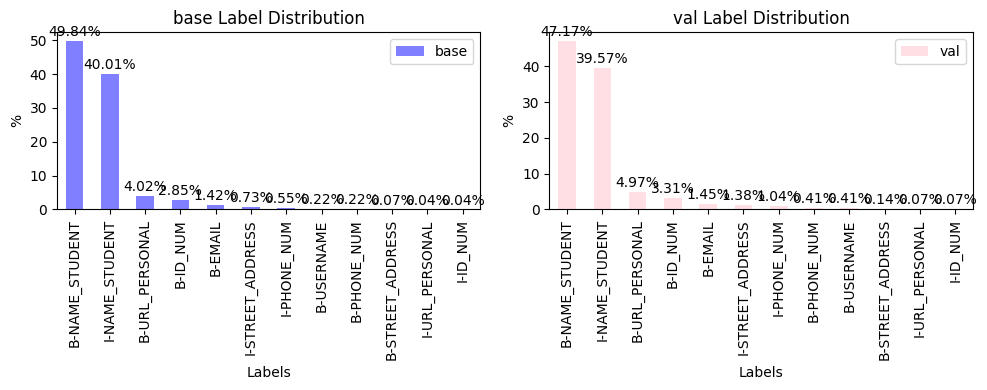

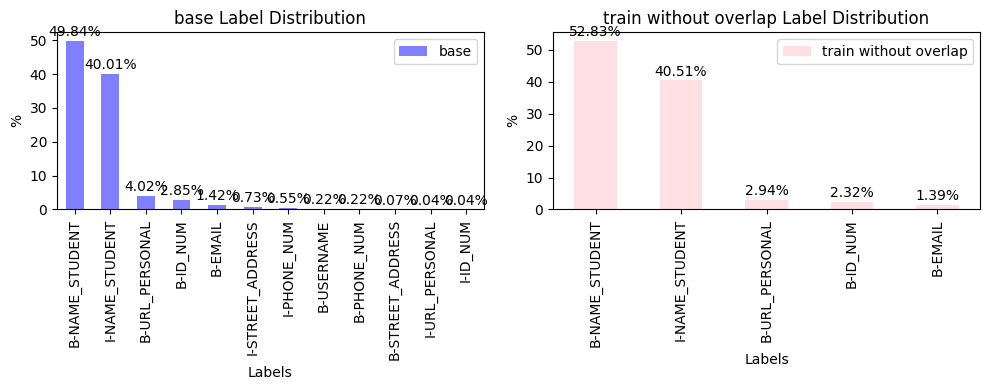

In [12]:
train2_df, val2_df = PIId2_split_by_sampling(base_df, .5)

val2_df, train2_df = move_rare_labels(val2_df, train2_df)

#train total
total_train_df = train2_df.copy()

analyze_labels(val2_df)

# Save the DataFrame to a JSON file 
val2_df.to_json(OUTPUT_DIR + "/val2.json", orient="records")
# train2_df.to_json(OUTPUT_DIR + "/train2_fromval.json", orient="records")

print("size of base: ", len(base_df))
print("size of val_df: ", len(val2_df))

graph_label_compare(base_df, val2_df, "base", "val")
graph_label_compare(base_df, train2_df, "base", "train without overlap")

## Miniset
mini_no_overlap, no_overlap_extra= PIId2_split_by_sampling(train2_df, .7)
mini_no_overlap, no_overlap_extra= move_missing_labels(mini_no_overlap, no_overlap_extra)

print("size of base: ", len(base_df))
print("size of mini_no_overlap: ", len(mini_no_overlap))
graph_label_compare(base_df, mini_no_overlap, "base", "train without overlap")

# More data
https://www.kaggle.com/code/valentinwerner/fix-punctuation-tokenization-external-dataset/output

valentinwerner fix of 
https://www.kaggle.com/datasets/alejopaullier/pii-external-dataset/data?select=pii_dataset.csv
https://www.kaggle.com/datasets/pjmathematician/pii-detection-dataset-gpt

In [13]:
#load external data

moredata_dataset_fixed_df = load_from_json('/kaggle/input/fix-punctuation-tokenization-external-dataset/moredata_dataset_fixed.json')
pii_dataset_fixed_df = load_from_json('/kaggle/input/fix-punctuation-tokenization-external-dataset/pii_dataset_fixed.json')
data_more2_fixed_df = load_from_json('/kaggle/input/data3-fixed/datamore2_fixed.json')
data_more3_fixed_df = load_from_json('/kaggle/input/data3-fixed/datamore3_fixed.json')

print(data_more2_fixed_df.head(1))
print(train2_df.head(1))

# Convert and standardize documents and add indices
ext_dfs = [moredata_dataset_fixed_df, pii_dataset_fixed_df, data_more2_fixed_df, data_more3_fixed_df]
ext_doc_numbering_seed = [100000 * (i + 1) for i in range(len(ext_dfs))]
for df, seed in zip(ext_dfs, ext_doc_numbering_seed):
    # Check if 'document' column exists
    if 'document' not in df.columns:
        # If not, add 'document' column
        df['document'] = range(seed, seed + len(df))
    else:
        # If 'document' column exists, convert it to int
        df['document'] = range(seed, seed + len(df['document']))
    total_train_df =  pd.concat([total_train_df, df], ignore_index=True)

# moredata_dataset_fixed_df.to_json(OUTPUT_DIR + "/moredata_dataset_fixed.json", orient="records")
# pii_dataset_fixed_df.to_json(OUTPUT_DIR + "/pii_dataset_fixed.json", orient="records")
# data_more2_fixed_df.to_json(OUTPUT_DIR + "/data_more2_fixed.json", orient="records")

                                           full_text  \
0  Ryan Gallagher is a student who is currently e...   

                                              tokens  \
0  [Ryan, Gallagher, is, a, student, who, is, cur...   

                                 trailing_whitespace  \
0  [True, True, True, True, True, True, True, Tru...   

                                              labels  \
0  [B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...   

                                       token_indices  
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
      document                                          full_text  \
3759     15694  Hello,\n\nThanks in advance for reviewing my s...   

                                                 tokens  \
3759  [Hello, ,, \n\n, Thanks, in, advance, for, rev...   

                                    trailing_whitespace  \
3759  [False, False, False, True, True, True, True, ...   

                                                 labels  \
37

In [14]:


print("train info", train2_df.info())
print("piifixed info", pii_dataset_fixed_df.info())
print("moredata info", moredata_dataset_fixed_df.info())
print("data_more2_fixed_df info", data_more2_fixed_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3401 entries, 3759 to 860
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             3401 non-null   int64 
 1   full_text            3401 non-null   object
 2   tokens               3401 non-null   object
 3   trailing_whitespace  3401 non-null   object
 4   labels               3401 non-null   object
 5   token_indices        3401 non-null   object
dtypes: int64(1), object(5)
memory usage: 186.0+ KB
train info None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4434 entries, 0 to 4433
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             4434 non-null   int64 
 1   full_text            4434 non-null   object
 2   tokens               4434 non-null   object
 3   trailing_whitespace  4434 non-null   object
 4   labels               4434 non-nu

In [15]:
# total_train_df.to_json(OUTPUT_DIR + "/total_train.json", orient="records")

# Ensemble training sets

In [16]:
#helper for split

def do_downsample(train_df, percent):
    '''
        Down sample negative examples
        percent- how much of the negative samples to keep- 0:none, 1:all
        
        return: 
        df- downsampled df
        n_remaining- n not used in downsampled df
    '''
    # Separate positive and negative samples
    p = train_df[train_df['labels'].apply(lambda x: any(label != "O" for label in x))]
    n = train_df[train_df['labels'].apply(lambda x: all(label == "O" for label in x))]

    # Downsample negative samples
    n = n.sample(int(len(n) * percent))
    n_percent, n_remaining = PIId2_split_by_sampling(n, percent)

    # Combine positive and downsampled negative samples
    df = pd.concat([p, n], ignore_index=True)
    
    return df, n_remaining

In [17]:
all_downsampled_train, n_remaining_train = do_downsample(total_train_df, .1)
len(all_downsampled_train)

7712

In [18]:
#Bagging

def create_bags(train_df, num_bags, bag_size, o_doc_weight,w_replace = True):
    '''
    o_doc_weigth = 1 if equal to all other classes
    '''
    bag_dfs ={}
    
    row_weights = train_df['labels'].apply(lambda x: o_doc_weight if all(label == "O" for label in x) else 1)
    
    for i in range(num_bags):
        
        bag_df = df.sample(n = bag_size, replace =w_replace, weights=row_weights)
#         bag_df.to_json(OUTPUT_DIR + f'train_bag{i}.json', orient="records")
        bag_dfs[f'train_bag{i}'] = bag_df
        
    return bag_dfs

In [19]:
print(len(total_train_df))

10379


In [20]:
total_train_df_overlap = pd.concat([total_train_df, val2_df], ignore_index=True)
print(len(total_train_df_overlap))

#TODO try submission with total_train_df_overlap
ens_train_dfs = create_bags(total_train_df, 10, 6000, 1, True)

13785


# split by class

In [21]:
total_train_df_overlap 

#get all possible labels
all_labels = sorted(list(set(chain(*val2_df.labels.values))))

print(all_labels)

entity_dfs = {}
for entity in all_labels:
    df = total_train_df_overlap[total_train_df_overlap['labels'].apply(lambda x: any(label == entity for label in x))]
    entity_dfs[f'by_class_{entity}'] = df

['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'O']


# Save to W and B

Running code below needs to have WANDB_API_KEY secret in kaggle secrets. Access api token through add-ons in notebook



In [22]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")



import wandb
wandb.login(key=wandb_api_key)
wandb.init(project='piiV2', job_type='preprocessing')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kasprisi (csci566sp24). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240503_184200-5fy3e0r4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run zany-blaze-57
wandb: ⭐️ View project at https://wandb.ai/csci566sp24/piiV2
wandb: 🚀 View run at https://wandb.ai/csci566sp24/piiV2/runs/5fy3e0r4/workspace


In [23]:
def log_dataframe_as_artifact(df, name, directory):
    """
    Save a DataFrame to a Parquet file and log it as a Weights & Biases artifact.

    Parameters:
    - df (DataFrame): The DataFrame to log.
    - name (str): The name to use for the Parquet file and the artifact.
    - directory (str): The directory to save the Parquet file.
    """
    # Create the full file path
    file_path = os.path.join(directory, f'{name}.parquet')

    # Save the DataFrame to a Parquet file
    df.to_parquet(file_path, index=False)

    # Create a new artifact
    artifact = wandb.Artifact(name, type="dataset")

    # Add the Parquet file to the artifact
    artifact.add_file(file_path)

    # Log the artifact
    wandb.log_artifact(artifact)

In [24]:
# Create the 'artifacts' directory if it doesn't exist
if not os.path.exists('artifacts'):
    os.makedirs('artifacts')

#train
log_dataframe_as_artifact(moredata_dataset_fixed_df, 'moredata_dataset_fixed', 'artifacts')
log_dataframe_as_artifact(pii_dataset_fixed_df, 'pii_dataset_fixed', 'artifacts')
log_dataframe_as_artifact(data_more2_fixed_df, 'data_more2_fixed', 'artifacts')
log_dataframe_as_artifact(data_more3_fixed_df, 'data_more3_fixed', 'artifacts')

log_dataframe_as_artifact(docs_over_3000, 'docs_over_3000', 'artifacts')
log_dataframe_as_artifact(docs_2000_2999, 'docs_2000_2999', 'artifacts')
log_dataframe_as_artifact(docs_1000_1999, 'docs_1000_1999', 'artifacts')
log_dataframe_as_artifact(docs_under_1000, 'docs_under_1000', 'artifacts')

log_dataframe_as_artifact(val2_df, 'val2', 'artifacts')
log_dataframe_as_artifact(train2_df, 'train2_fromval', 'artifacts')
log_dataframe_as_artifact(total_train_df,'total_train', 'artifacts')

#log bagging dfs
for k,v in ens_train_dfs.items():
    log_dataframe_as_artifact(v,k, 'artifacts')
    
#log class dfs

for k,v in entity_dfs.items():
    log_dataframe_as_artifact(v,k, 'artifacts')

In [25]:
# Finish W&B run
wandb.finish()

wandb:                                                                                
wandb: 🚀 View run zany-blaze-57 at: https://wandb.ai/csci566sp24/piiV2/runs/5fy3e0r4/workspace
wandb: Synced 4 W&B file(s), 0 media file(s), 12 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240503_184200-5fy3e0r4/logs
